In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import global_data
import pandas as pd

In [3]:
df = global_data.get_global_covid_df()

In [4]:
len(df.country.value_counts().to_dict()), len(df)

(176, 11616)

In [5]:
df = df.merge(
    df.groupby('country').confirmed.max().reset_index().rename(columns={'confirmed': 'total_confirmed'}),
    on='country'
)

In [24]:
from sklearn.linear_model import LinearRegression
import numpy as np

def get_lr(country, start, end=None):
    full_c_df = df[df.country == country]
    c_df = full_c_df.sort_values('date')[-start:]
    if end: c_df = cdf[:-end]
    else: end = 0

    X = c_df.days_from_tenth_infection.values.reshape((-1,1)) - c_df.days_from_tenth_infection.min()
    y_orig = c_df.confirmed.values
    y = np.log(y_orig + 1)

    lr = LinearRegression(fit_intercept=True)
    lr.fit(X, y)

    X_fore = np.linspace(X.min(), X.max() + 5 + end, len(X) + 5 + end)
    y_forecast = np.exp(lr.predict(X_fore.reshape((-1, 1)))) - 1
    
    x_pred = X_fore + c_df.days_from_tenth_infection.min()
    
    return {
        'forecast': y_forecast, 
        'infected': full_c_df.confirmed.max(),
        'fore': list(map(int, y_forecast[-4:])),
        'x_pred': x_pred, 
        'coef_': lr.coef_[0], 
        'intercept_': lr.intercept_, 
        'mae': np.abs(((y_orig - np.exp(lr.predict(X)) - 1) / y_orig)).mean(),
#         'days': days, 
        'country': country,
        'last_day': c_df.date.max()
    }

2020-03-20 00:00:00


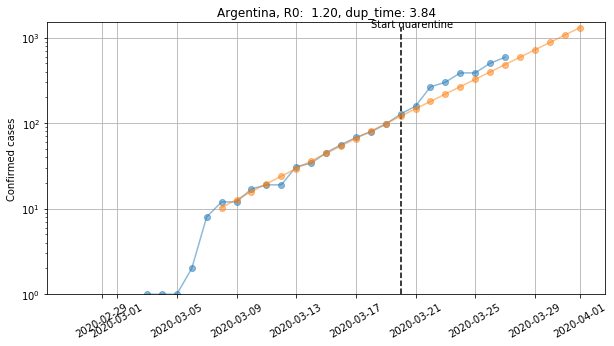

In [16]:
import math
from datetime import timedelta


doc = get_lr('Argentina', 20, 7)

c_df = df[df.country == doc['country']]

plt.figure(figsize=(10,5))

plt.plot(c_df.date[-30:], c_df.confirmed[-30:], '-o', alpha=0.5)
plt.plot(
    [timedelta(days=x) + c_df.tenth_infaction_date.min() for x in doc['x_pred']],
    doc['forecast'], 
    '-o', alpha=0.5
)

plt.vlines(doc['last_day'], 1, doc['forecast'].max(), linestyle='--')
plt.text(doc['last_day'] - timedelta(days=2), doc['forecast'].max() + 20, 'Start quarentine', )
print(doc['last_day'])

plt.ylim(1, plt.ylim()[1] * 1.1)
plt.title(f"{doc['country']}, R0: {doc['coef_'] + 1: .02f}, dup_time: {math.log(2, doc['coef_'] + 1):.02f}")
plt.grid()
plt.ylabel('Confirmed cases')
plt.xticks(rotation=30)
          
plt.yscale('log')

# Do it for the rest of the world

In [25]:
docs = []
for c, cnt in df.dropna()[df.dropna().confirmed > 0].country.value_counts().to_dict().items():
    if cnt < 20: continue
        
    docs.append(get_lr(c, 10))

In [27]:
docs.sort(key=lambda x: x['mae'])

In [28]:
pd.DataFrame(docs).drop(['forecast', 'x_pred'], axis=1).sort_values('coef_', ascending=False)

,infected,fore,coef_,intercept_,mae,country,last_day
39,581,"[1675, 2404, 3450, 4952]",0.361232,3.450618,0.238952,Dominican Republic,2020-03-27
40,1595,"[3809, 5029, 6640, 8768]",0.277861,5.188928,0.246369,Ecuador,2020-03-27
35,101657,"[198306, 259718, 340147, 445483]",0.269781,9.229987,0.097841,US,2020-03-27
28,3035,"[5481, 7109, 9220, 11958]",0.259993,5.749362,0.073076,Israel,2020-03-27
37,3417,"[6679, 8478, 10762, 13660]",0.238457,6.183941,0.112315,Brazil,2020-03-27
31,4268,"[7519, 9484, 11961, 15085]",0.232032,6.373095,0.087417,Portugal,2020-03-27
21,4682,"[7952, 10004, 12585, 15833]",0.229538,6.456410,0.043592,Canada,2020-03-27
36,589,"[1050, 1321, 1660, 2087]",0.228713,4.442402,0.105203,Argentina,2020-03-27
38,1605,"[3015, 3738, 4635, 5746]",0.214903,5.647882,0.136917,Luxembourg,2020-03-27
9,345,"[516, 638, 789, 975]",0.211373,3.924297,0.022986,Morocco,2020-03-27


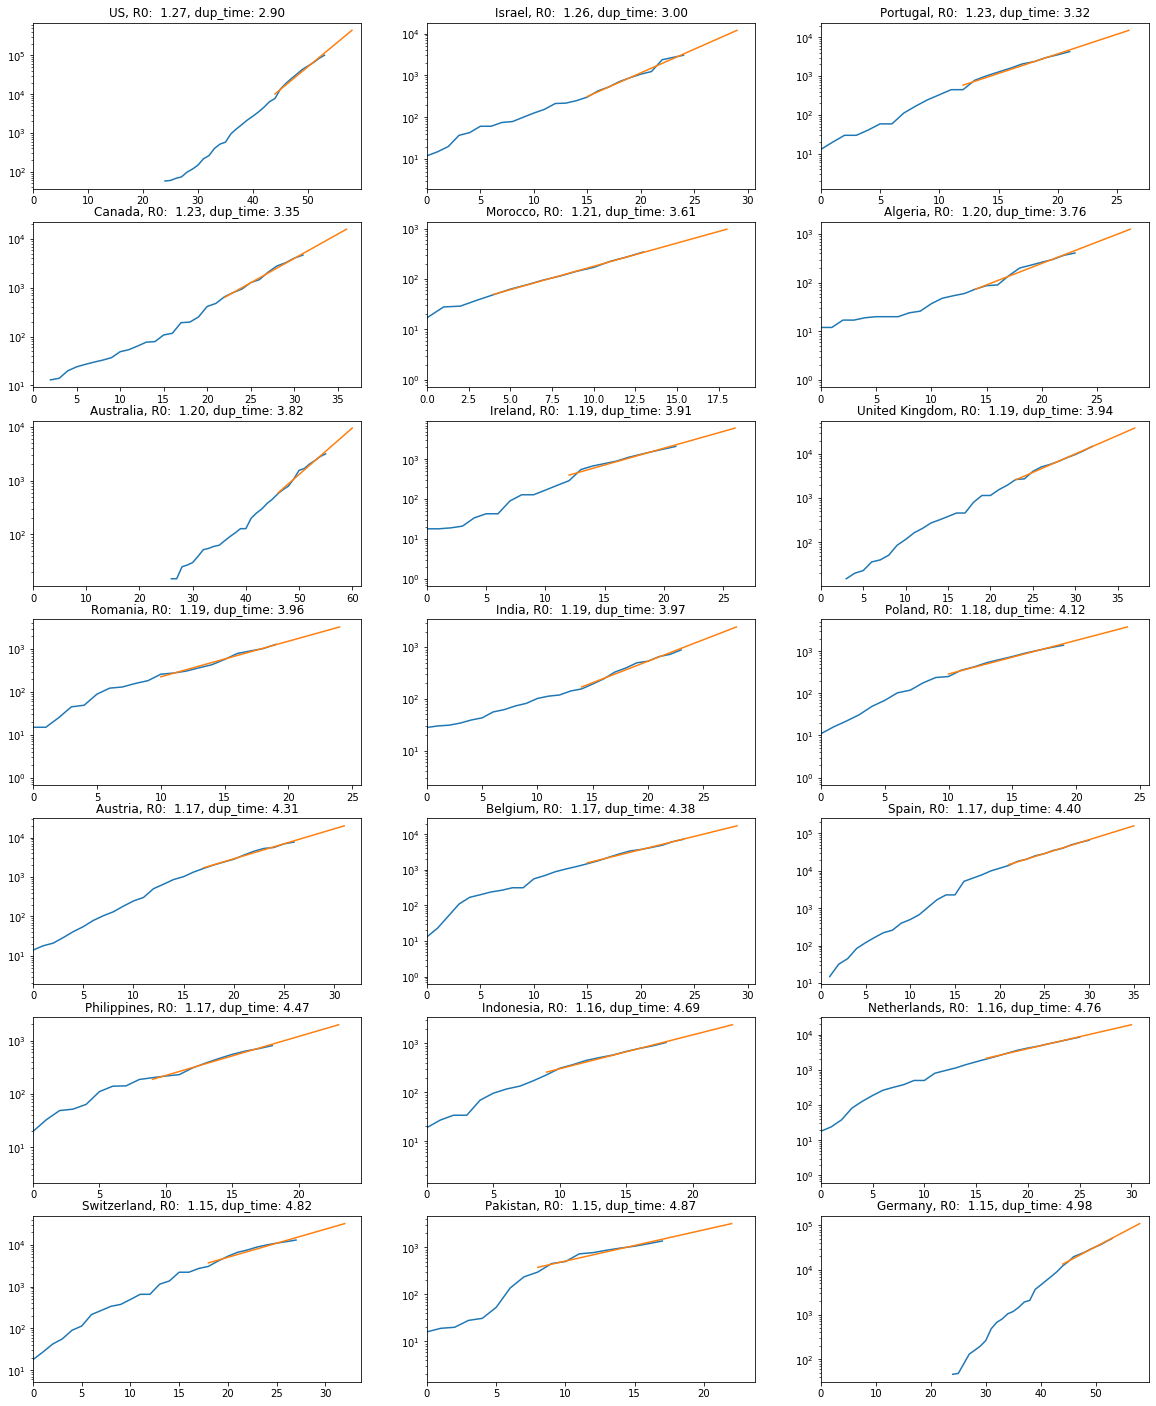

In [30]:
fig, axs = plt.subplots(7, 3, figsize=(20, 25))
axs = axs.reshape(-1)
for i, doc in enumerate([d for d in sorted(docs, key=lambda x: -x['coef_']) if d['mae'] < 0.1][:21]):
    c_df = df[df.country == doc['country']]
    axs[i].semilogy(c_df.days_from_tenth_infection[-30:], c_df.confirmed[-30:])
    axs[i].semilogy(doc['x_pred'], doc['forecast'])
    axs[i].set_xlim(0, axs[i].get_xlim()[1])
    axs[i].set_title(f"{doc['country']}, R0: {doc['coef_'] + 1: .02f}, dup_time: {math.log(2, doc['coef_'] + 1):.02f}")